0.0 1.0


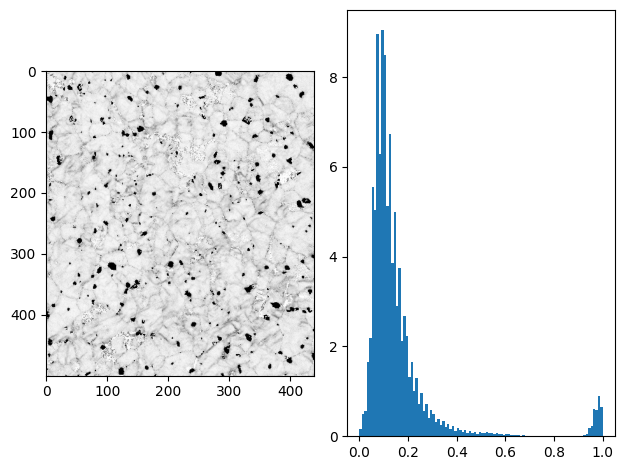

In [51]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import copy
import pandas as pd
import dionysus as d
import networkx
from tqdm.auto import tqdm

# im_test = np.array(Image.open("../figures/GND15pct_rotated.jpg").convert("RGB"))
# im_gray = 1-np.array(Image.open("../figures/GND0pct_rotated.jpg").convert("L").resize((100,100))).astype(int)/255
im_gray = 1-np.array(Image.open("../figures/GND10pct_rotated.jpg").convert("L")).astype(int)/255
# im_norm = im_test.astype(int)/255
print(np.min(im_gray), np.max(im_gray))
fig, ax = plt.subplots(1,2)
ax[0].imshow(im_gray, cmap="gray_r")
ax[1].hist(im_gray.flatten(), bins=100, density=True)
fig.tight_layout()
plt.show()

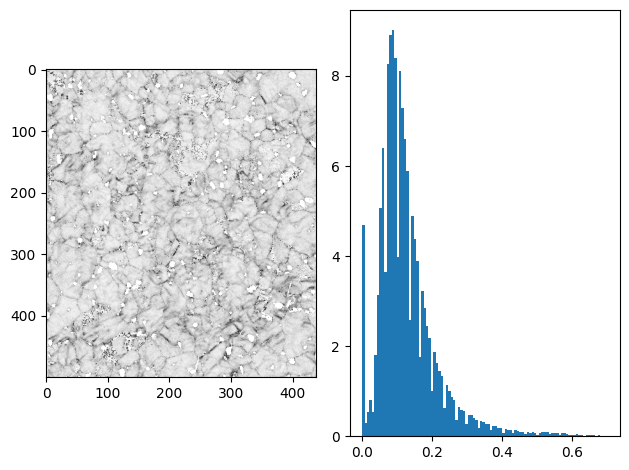

In [52]:
im_red = copy.deepcopy(im_gray)
im_red[im_red > 0.8] = 0
fig, ax = plt.subplots(1,2)
ax[0].imshow(im_red, cmap="gray_r")
ax[1].hist(im_red.flatten(), bins=100, density=True)
fig.tight_layout()
plt.show()

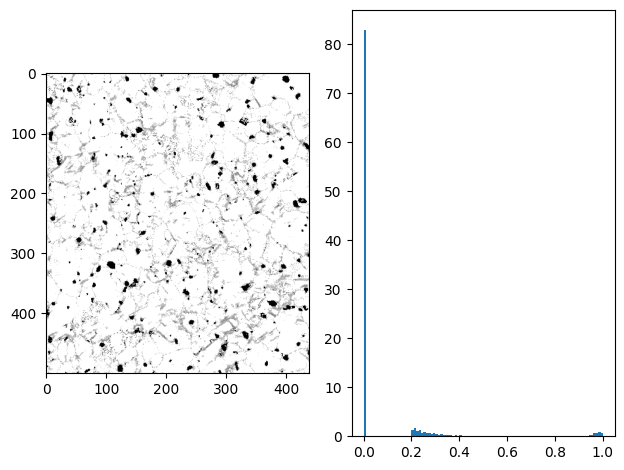

In [53]:
im_grain = copy.deepcopy(im_gray)
im_grain[im_grain < 0.20] = 0
fig, ax = plt.subplots(1,2)
ax[0].imshow(im_grain, cmap="gray_r")
ax[1].hist(im_grain.flatten(), bins=100, density=True)
fig.tight_layout()
plt.show()

Amount of points: 37714


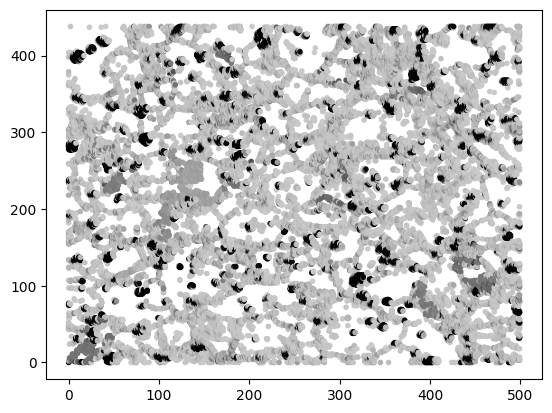

In [54]:
X = np.vstack(np.where(im_gray>0.20)).T
y = [im_gray[X[i,0], X[i,1]] for i in range(X.shape[0])]
print("Amount of points:", len(y))
plt.scatter(X[:,0], X[:,1], marker=".", c=y, cmap="gray_r", vmin=0, vmax=1)

In [55]:
from sklearn.datasets import make_circles
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

from tdamapper.learn import MapperAlgorithm
from tdamapper.cover import CubicalCover
from tdamapper.plot import MapperPlot

# load a labelled dataset
# X, labels = make_circles(n_samples=5000, noise=0.05, factor=0.3, random_state=42)
# y = X[:,1]

cover = CubicalCover(n_intervals=25, overlap_frac=0.2, algorithm="standard")
clust = DBSCAN(eps=5)
graph = MapperAlgorithm(cover, clust).fit_transform(X, X)

# color according to labels
fig = MapperPlot(graph, dim=2, seed=42, iterations=60, layout_engine="networkx").plot_plotly(colors=y, cmap="gray_r")
fig.show(config={'scrollZoom': True})


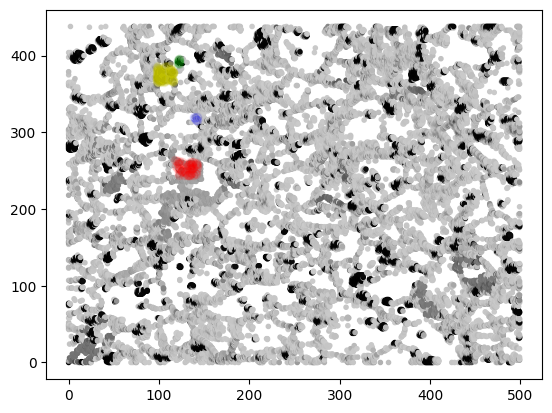

In [56]:
plt.scatter(X[:,0], X[:,1], marker=".", c=y, cmap="gray_r", vmin=0, vmax=1)
plt.scatter(X[graph.nodes[683]["ids"],0], X[graph.nodes[683]["ids"],1], marker="o", c="y", alpha=0.1)
plt.scatter(X[graph.nodes[681]["ids"],0], X[graph.nodes[681]["ids"],1], marker="o", c="g", alpha=0.1)
plt.scatter(X[graph.nodes[653]["ids"],0], X[graph.nodes[653]["ids"],1], marker="o", c="b", alpha=0.1)
plt.scatter(X[graph.nodes[654]["ids"],0], X[graph.nodes[654]["ids"],1], marker="o", c="r", alpha=0.1)


  0%|          | 0/3 [00:00<?, ?it/s]

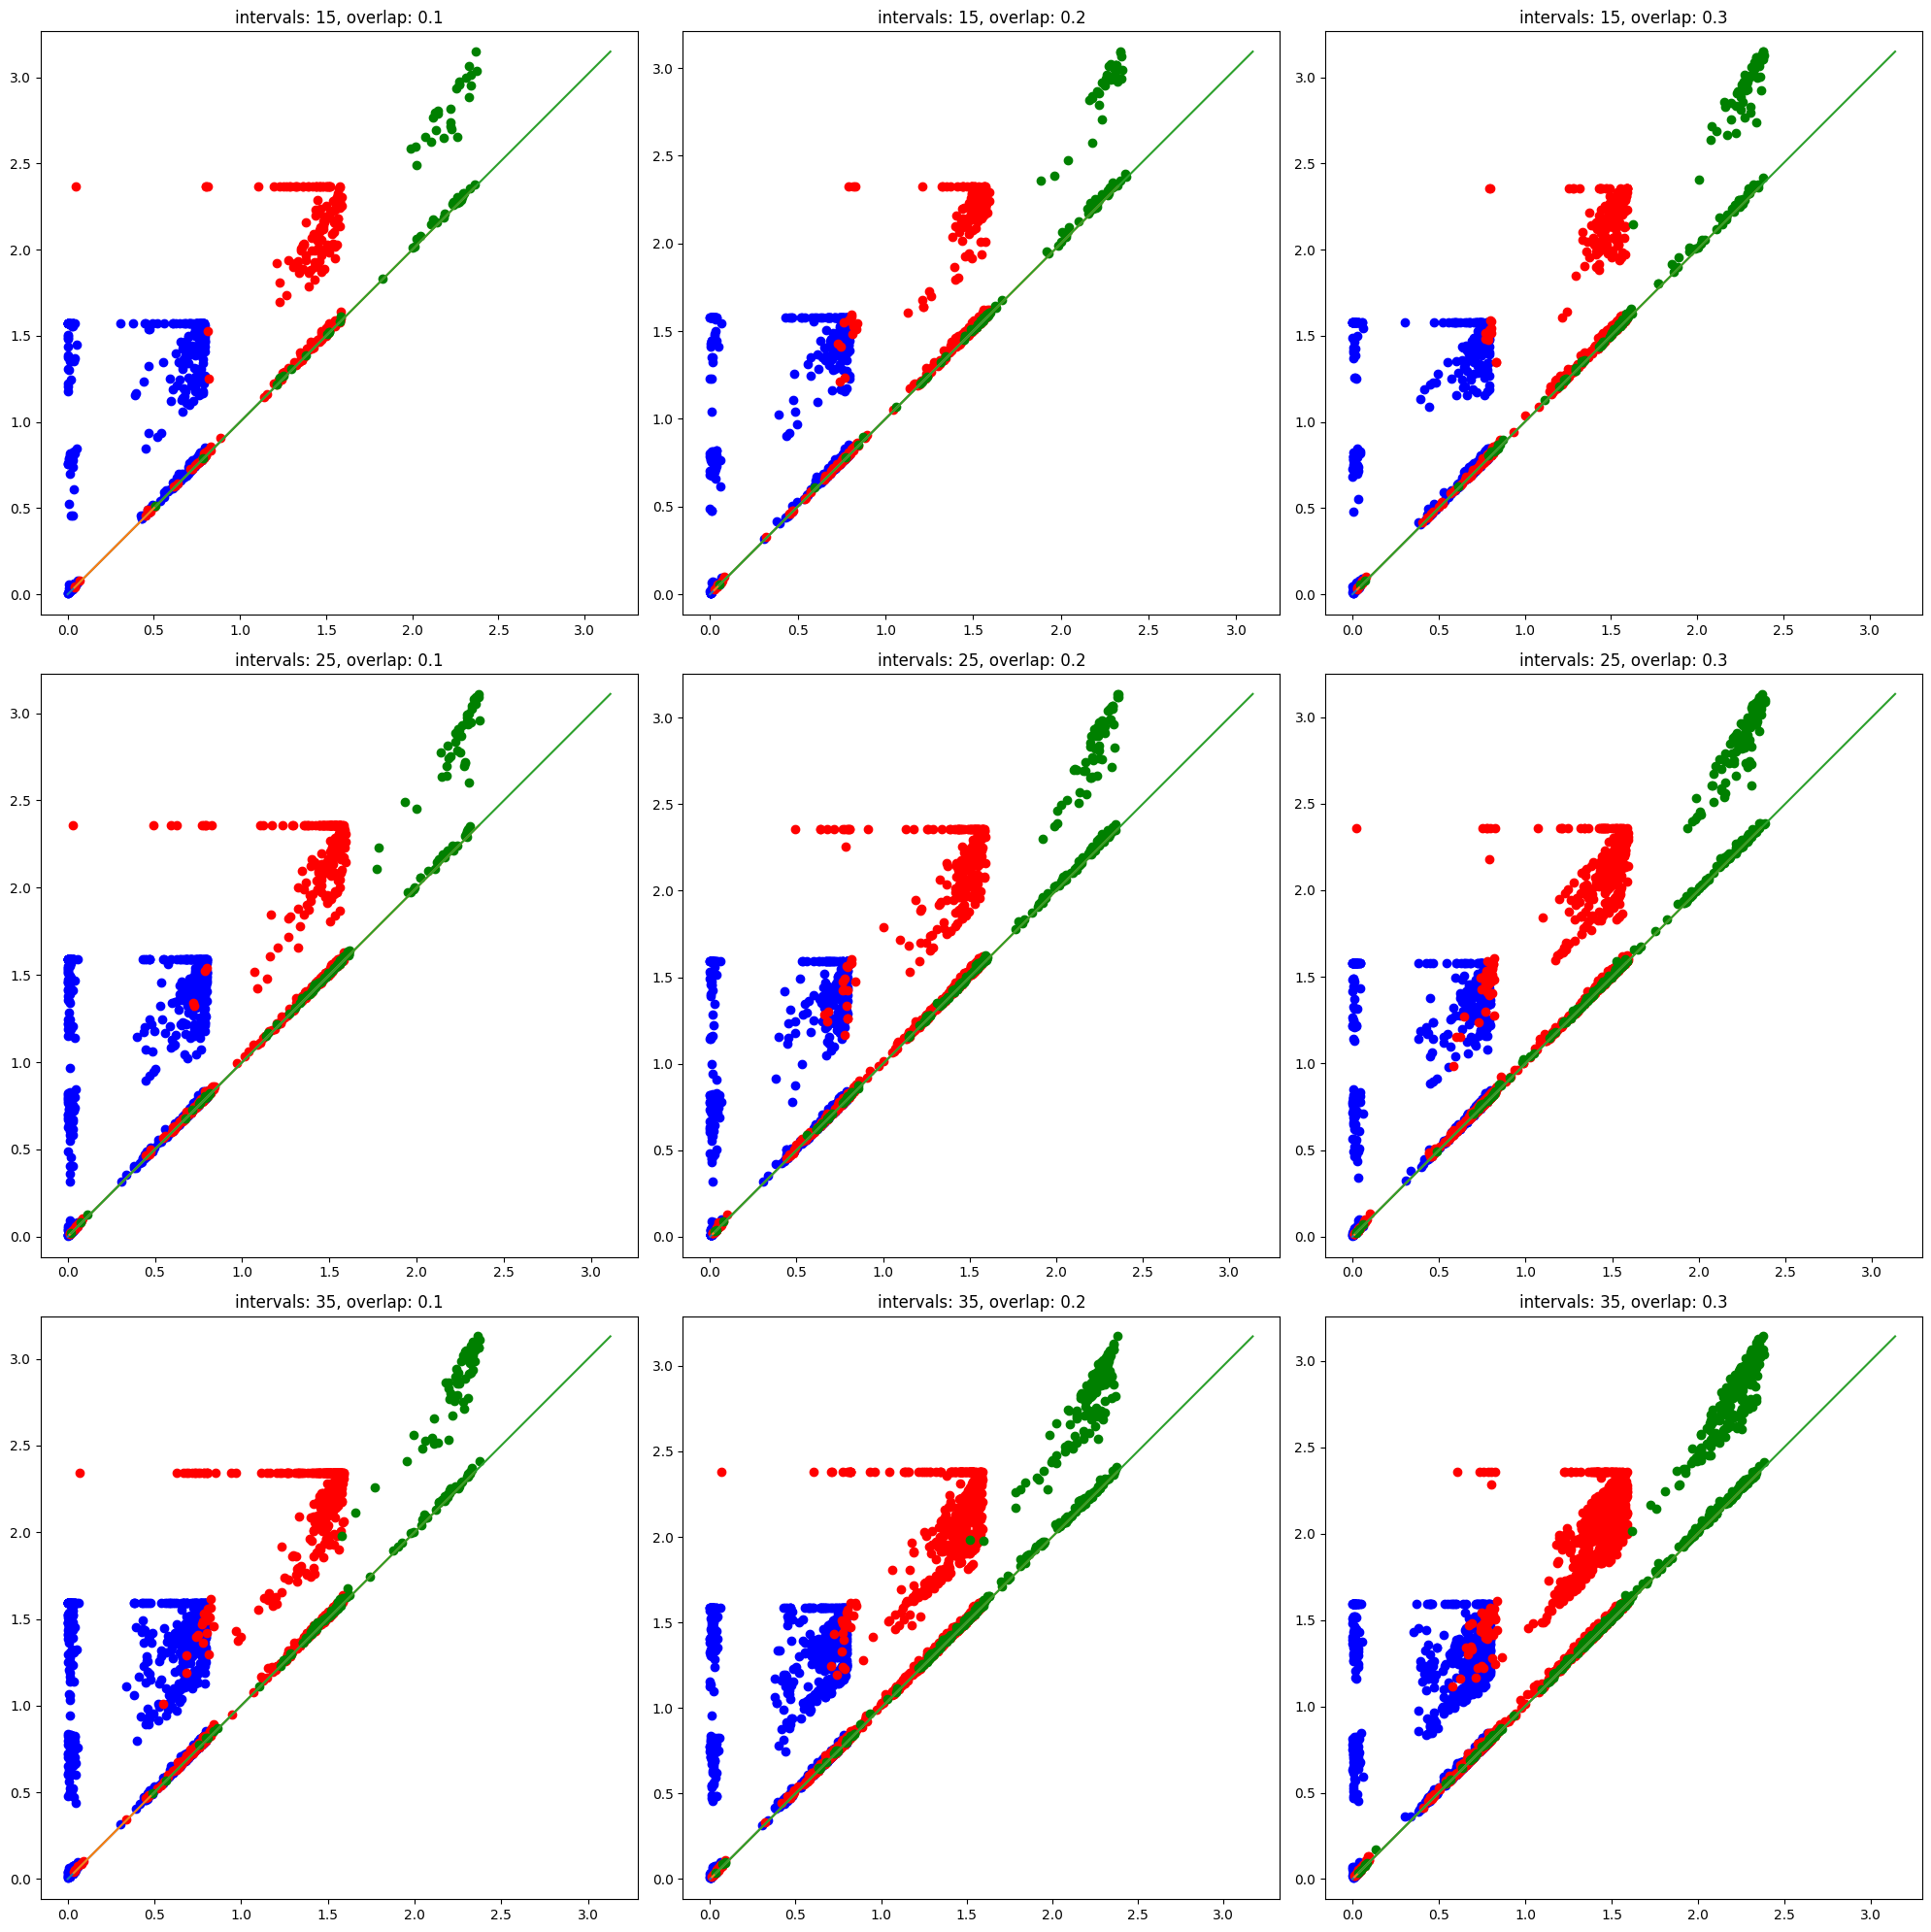

In [57]:
fig, ax = plt.subplots(3,3)
fig.set_size_inches(20,20)

interval_bar = tqdm([15, 25, 35])

for ax_i, n_intervals in enumerate(interval_bar):
    for ax_j, overlap_frac in enumerate([0.1,0.2,0.3]):
        interval_bar.set_description(f"overlap_frac: {overlap_frac}")

        cover = CubicalCover(n_intervals=n_intervals, overlap_frac=overlap_frac, algorithm="standard")
        clust = DBSCAN(eps=5)
        graph = MapperAlgorithm(cover, clust).fit_transform(X, X)

        simplices = []
        for c in networkx.enumerate_all_cliques(graph):
            simplices.append((c, np.sum([1-y[i] for i in c])))

        f = d.Filtration()
        for vertices, time in simplices:
            f.append(d.Simplex(vertices, time))
        f.sort()
        p = d.cohomology_persistence(f, prime=47)
        dgms = d.init_diagrams(p, f)
        d.plot.plot_diagram(dgms[0], ax=ax[ax_i, ax_j], pt_style={"c":"b"})
        d.plot.plot_diagram(dgms[1], ax=ax[ax_i, ax_j], pt_style={"c":"r"})
        d.plot.plot_diagram(dgms[2], ax=ax[ax_i, ax_j], pt_style={"c":"g"})
        ax[ax_i, ax_j].set_title(f"intervals: {n_intervals}, overlap: {overlap_frac}")
plt.tight_layout()

  0%|          | 0/3 [00:00<?, ?it/s]

Didn't work for n: 20, eps: 1


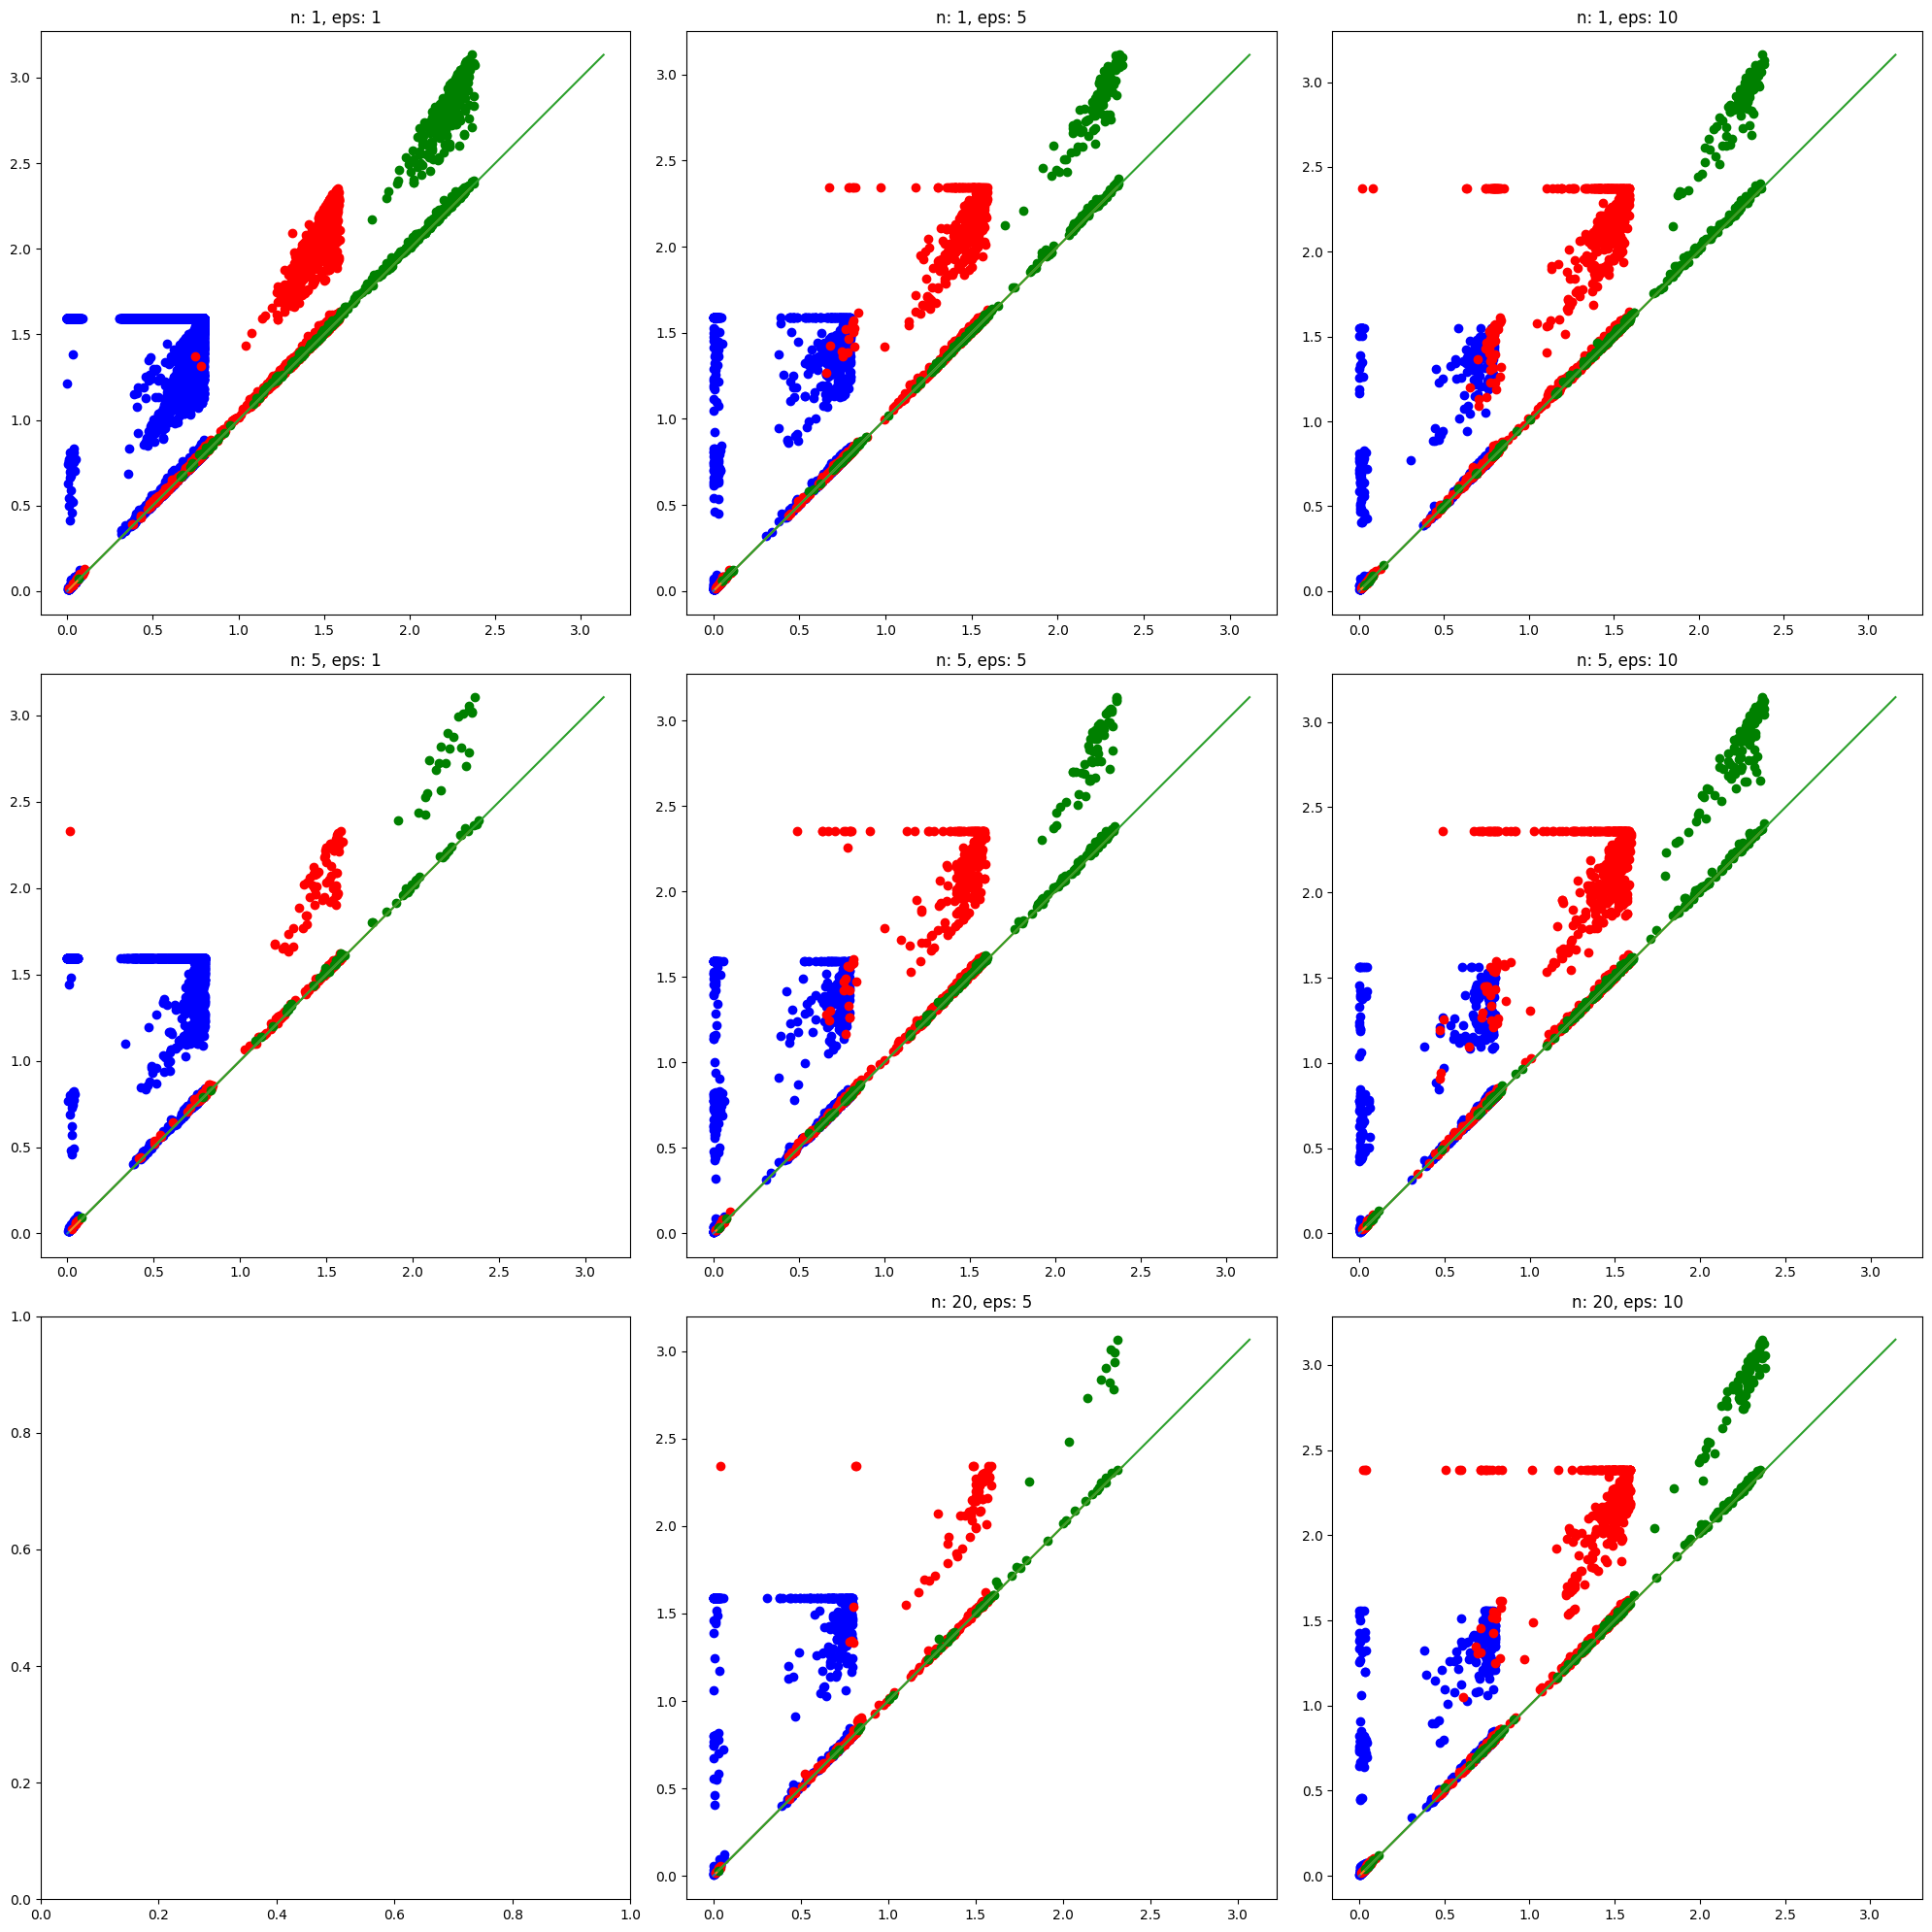

In [58]:
fig, ax = plt.subplots(3,3)
fig.set_size_inches(20,20)

samples_bar = tqdm([1, 5, 20])

for ax_i, dbscan_min_samples in enumerate(samples_bar):
    for ax_j, dbscan_eps in enumerate([1,5,10]):
        samples_bar.set_description(f"dbscan_eps: {dbscan_eps}")

        cover = CubicalCover(n_intervals=25, overlap_frac=0.2, algorithm="standard")
        clust = DBSCAN(eps=dbscan_eps, min_samples = dbscan_min_samples)
        graph = MapperAlgorithm(cover, clust).fit_transform(X, X)

        simplices = []
        for c in networkx.enumerate_all_cliques(graph):
            simplices.append((c, np.sum([1-y[i] for i in c])))

        f = d.Filtration()
        for vertices, time in simplices:
            f.append(d.Simplex(vertices, time))
        f.sort()
        p = d.cohomology_persistence(f, prime=47)
        dgms = d.init_diagrams(p, f)
        try:
            d.plot.plot_diagram(dgms[0], ax=ax[ax_i, ax_j], pt_style={"c":"b"})
        except:
            print(f"Didn't work for n: {dbscan_min_samples}, eps: {dbscan_eps}")
            continue
        d.plot.plot_diagram(dgms[1], ax=ax[ax_i, ax_j], pt_style={"c":"r"})
        d.plot.plot_diagram(dgms[2], ax=ax[ax_i, ax_j], pt_style={"c":"g"})
        ax[ax_i, ax_j].set_title(f"n: {dbscan_min_samples}, eps: {dbscan_eps}")
plt.tight_layout()

  0%|          | 0/5 [00:00<?, ?it/s]

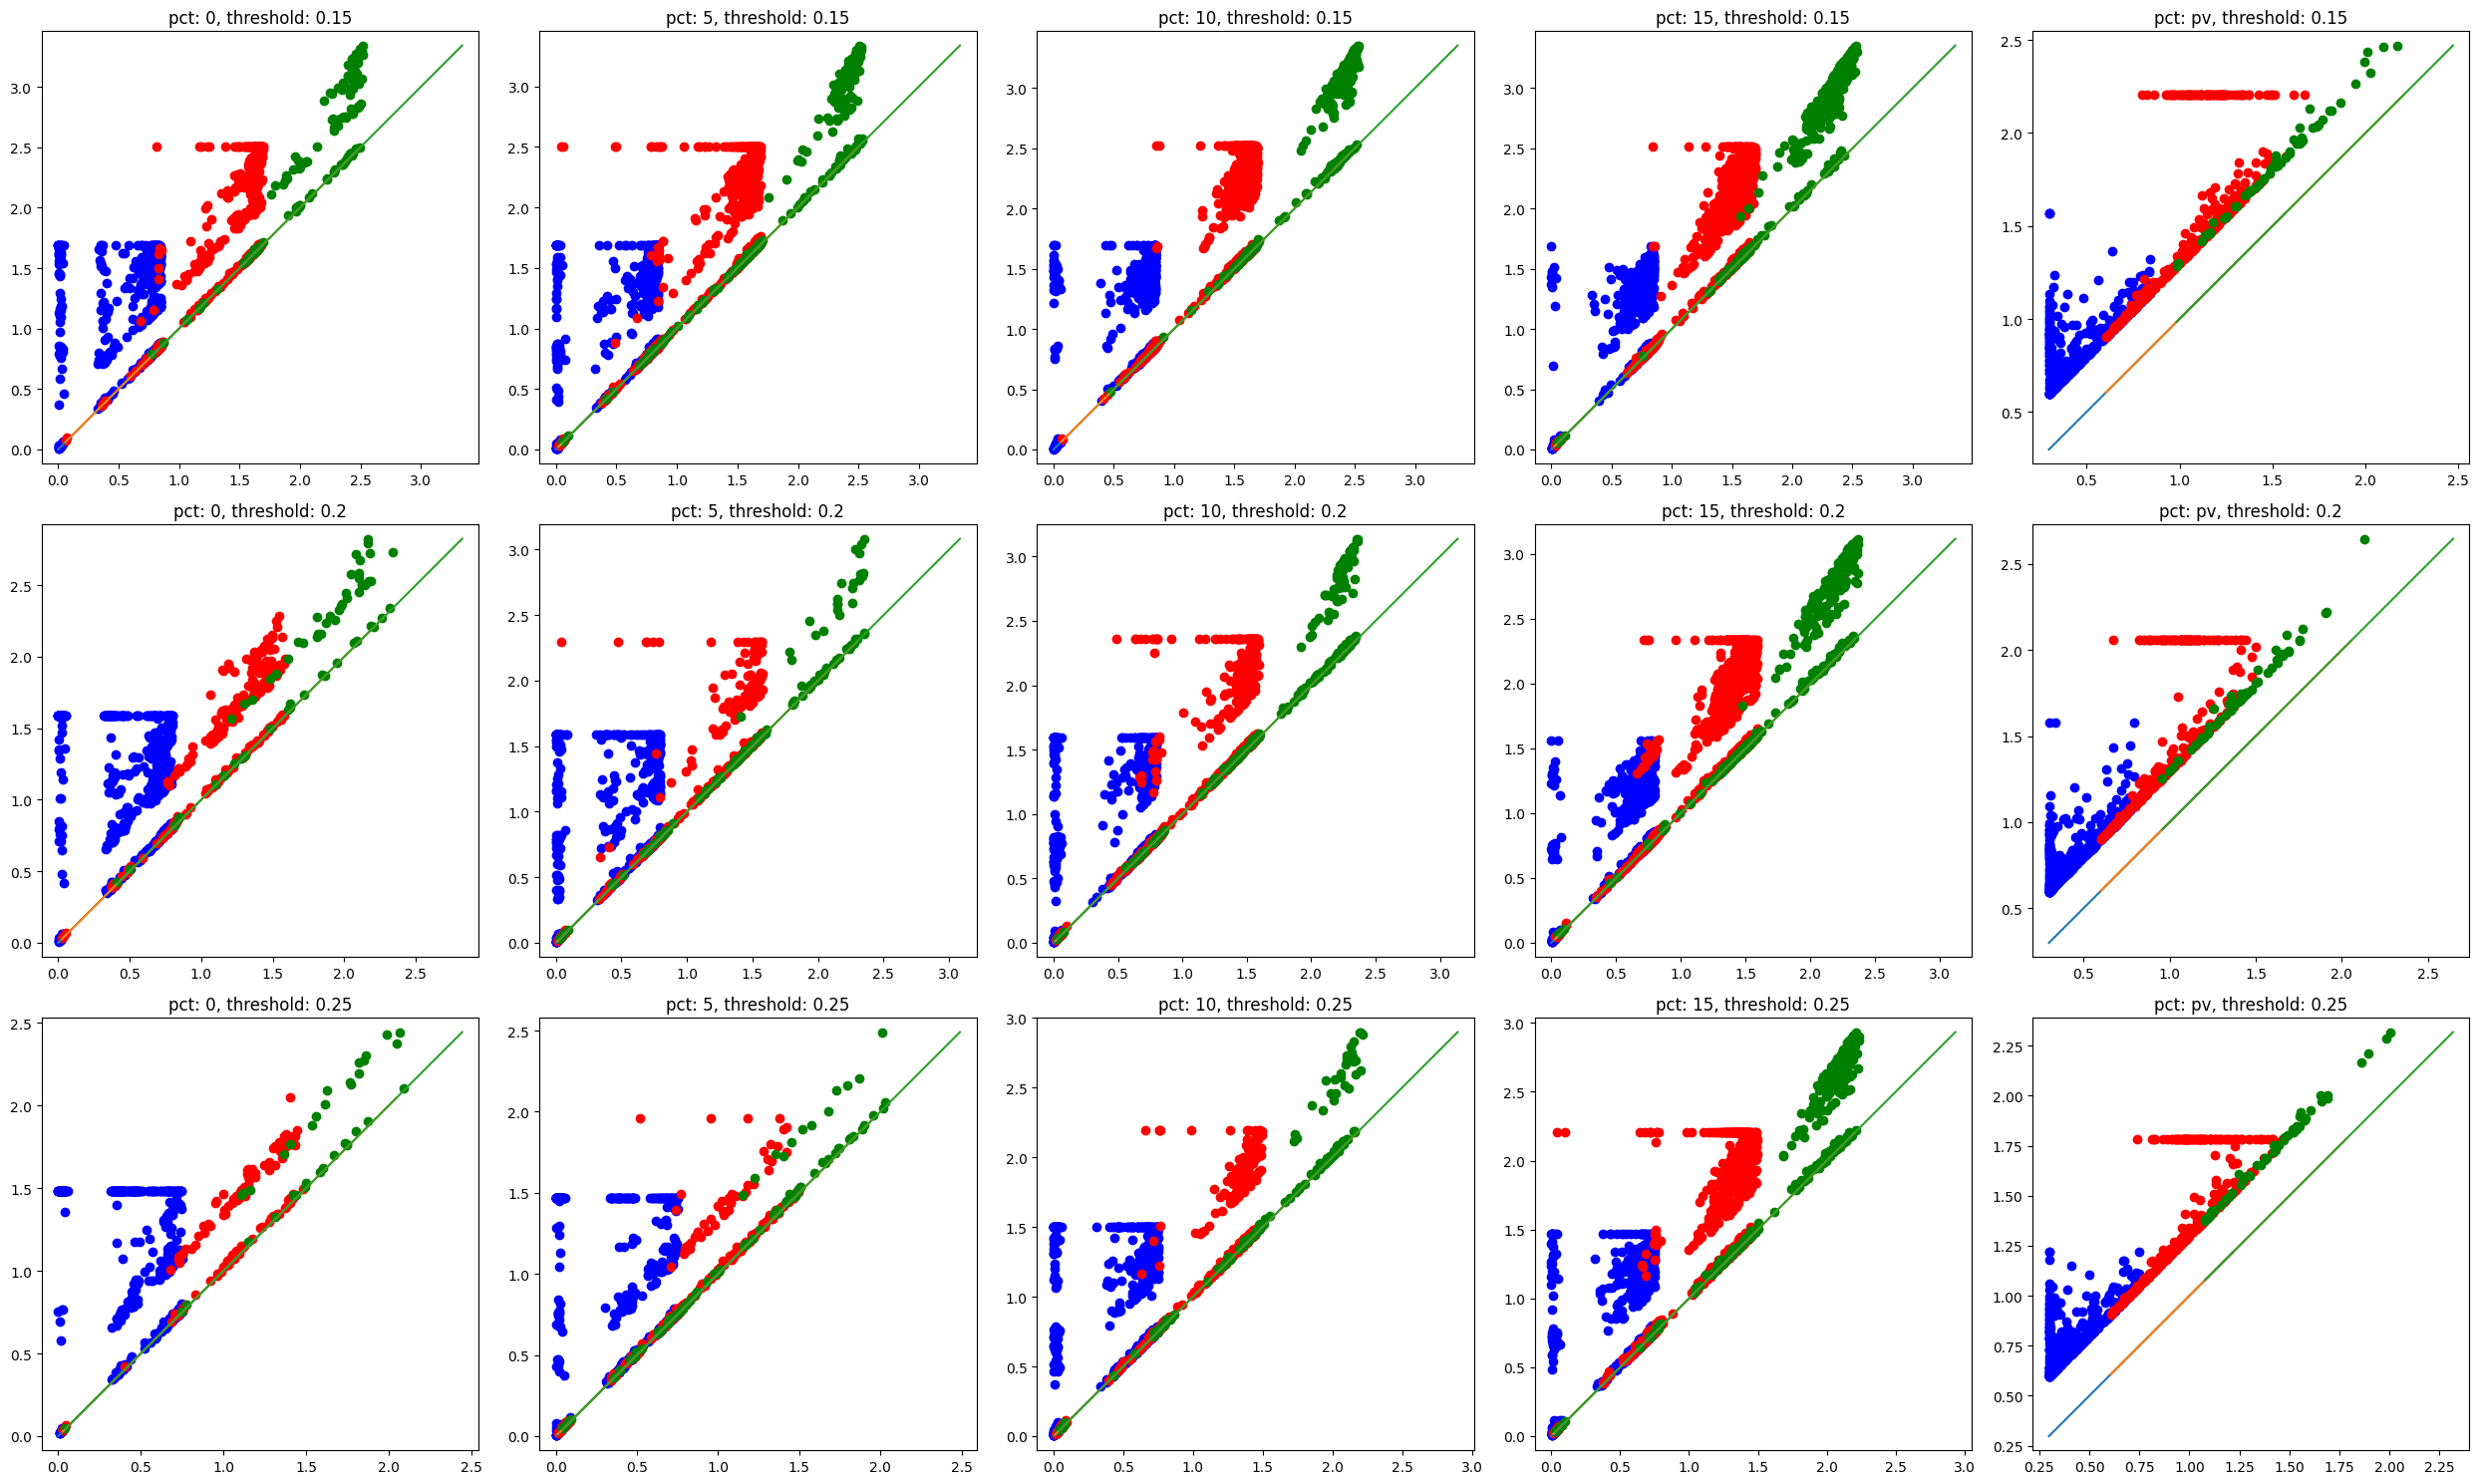

In [59]:
fig, ax = plt.subplots(3,5)
fig.set_size_inches(25,15)

pct_bar = tqdm(["0", "5", "10", "15", "pv"])


for ax_j, pct in enumerate(pct_bar):
    for ax_i, threshold in enumerate([0.15,0.2,0.25]):
        if pct != "pv":
            im_gray = 1-np.array(Image.open(f"../figures/GND{pct}pct_rotated.jpg").convert("L")).astype(int)/255
        else:
            im_gray = 1-np.array(Image.open(f"../figures/tot10_0_2d.png").convert("L")).astype(int)/255

        X = np.vstack(np.where(im_gray>threshold)).T
        y = [im_gray[X[i,0], X[i,1]] for i in range(X.shape[0])]

        pct_bar.set_description(f"threshold: {threshold}")

        cover = CubicalCover(n_intervals=25, overlap_frac=0.2, algorithm="standard")
        clust = DBSCAN(eps=5)
        graph = MapperAlgorithm(cover, clust).fit_transform(X, X)

        simplices = []
        for c in networkx.enumerate_all_cliques(graph):
            simplices.append((c, np.sum([1-y[i] for i in c])))

        f = d.Filtration()
        for vertices, time in simplices:
            f.append(d.Simplex(vertices, time))
        f.sort()
        p = d.cohomology_persistence(f, prime=47)
        dgms = d.init_diagrams(p, f)
        d.plot.plot_diagram(dgms[0], ax=ax[ax_i, ax_j], pt_style={"c":"b"})
        d.plot.plot_diagram(dgms[1], ax=ax[ax_i, ax_j], pt_style={"c":"r"})
        d.plot.plot_diagram(dgms[2], ax=ax[ax_i, ax_j], pt_style={"c":"g"})
        ax[ax_i, ax_j].set_title(f"pct: {pct}, threshold: {threshold}")
plt.tight_layout()

  0%|          | 0/4 [00:00<?, ?it/s]

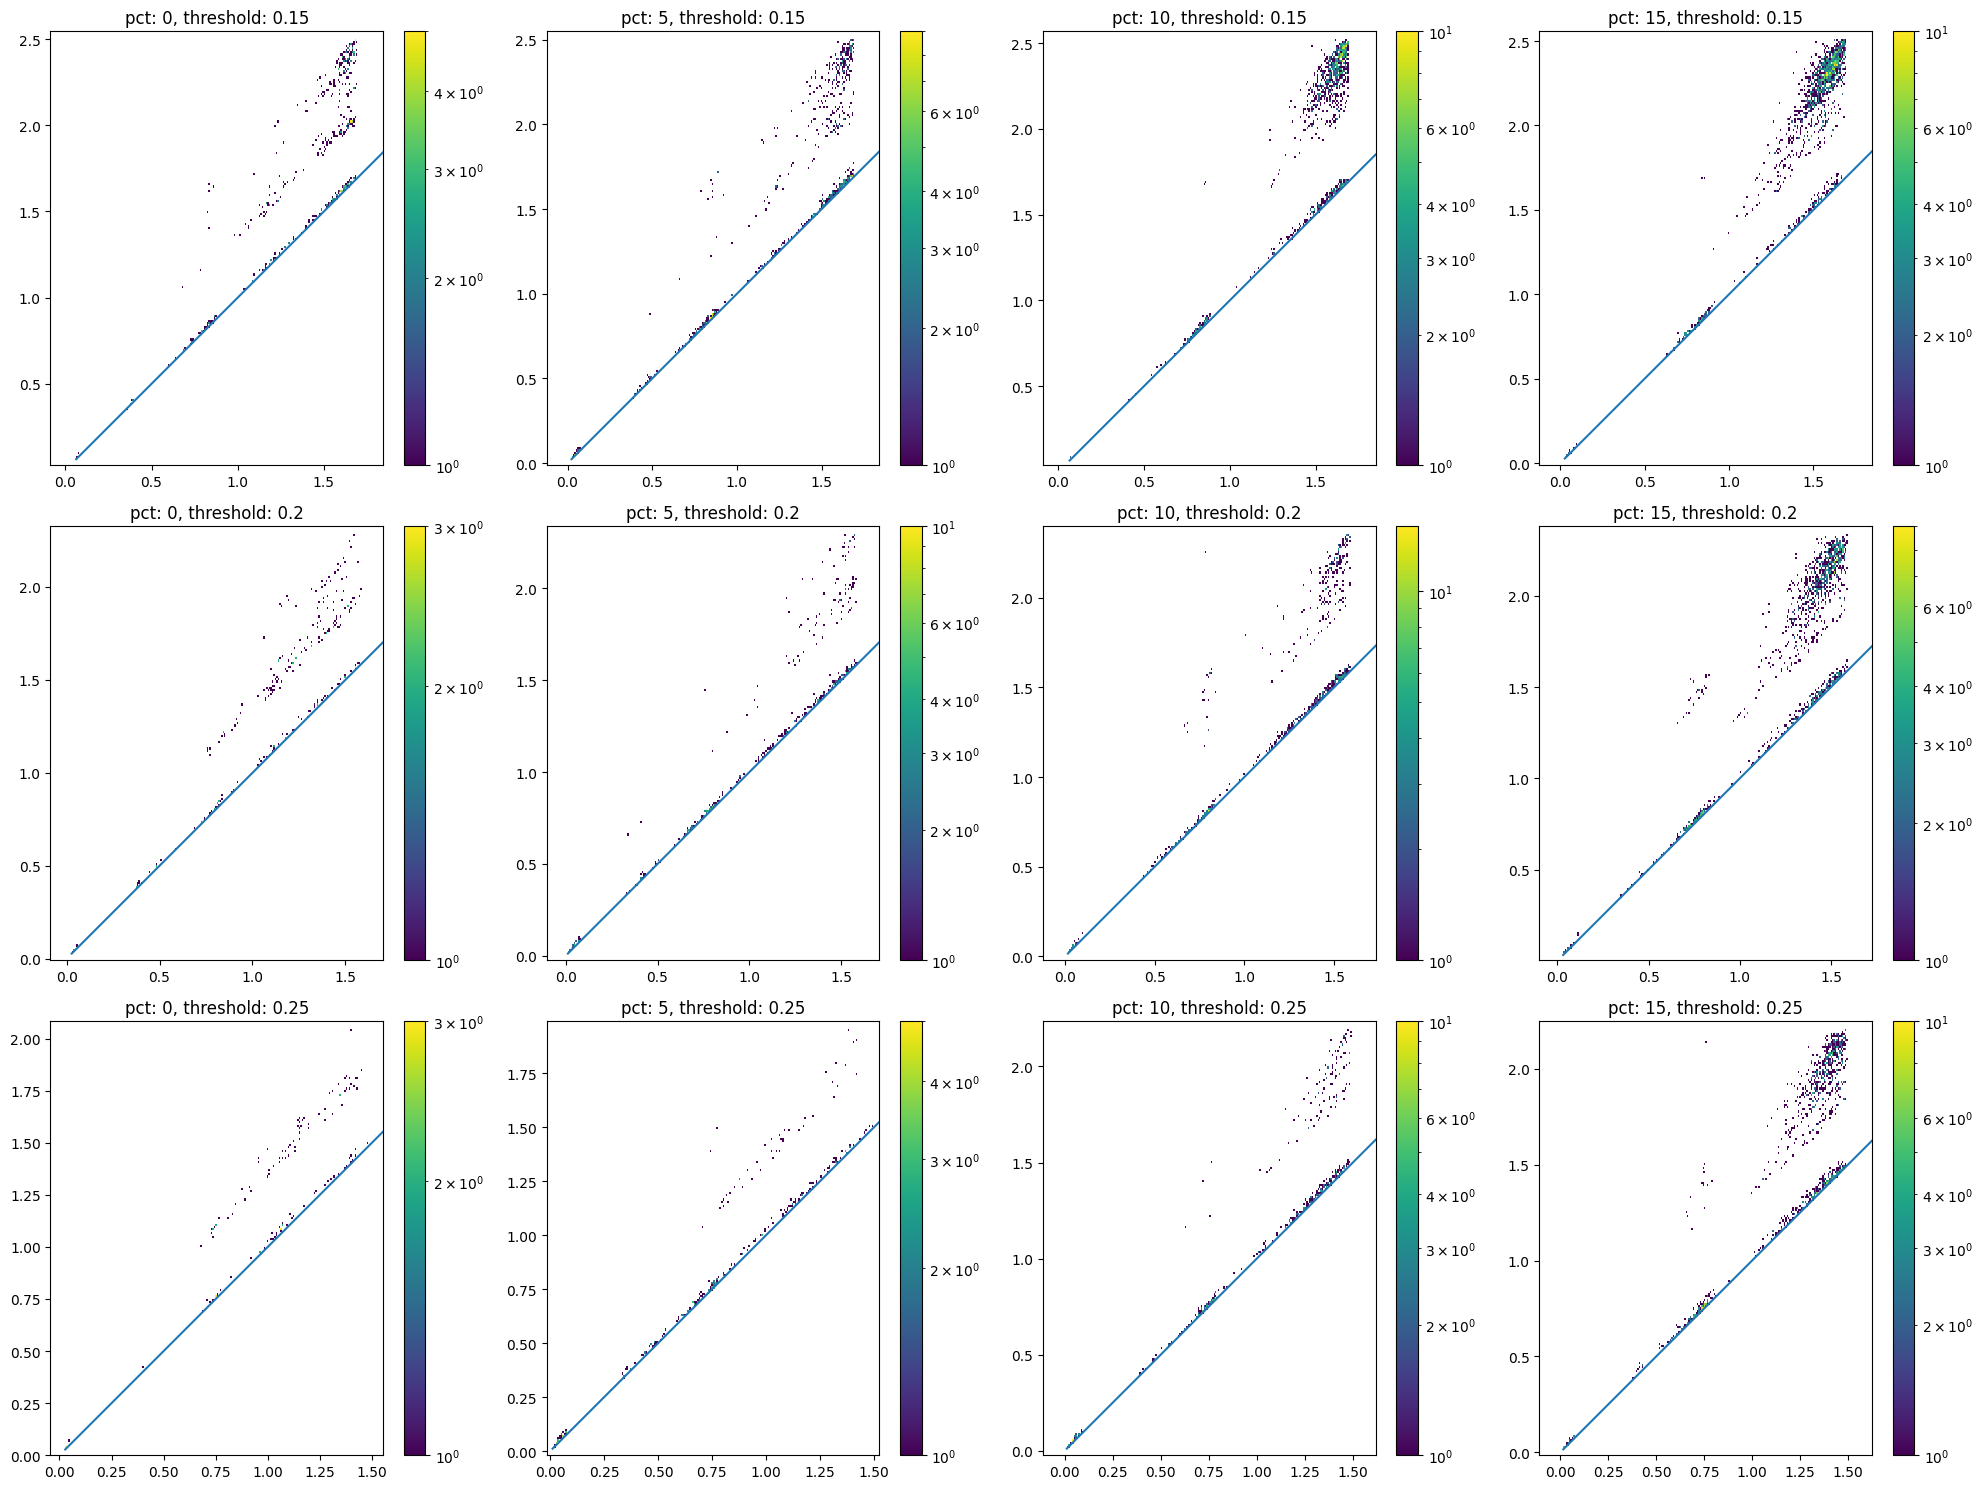

In [60]:
fig, ax = plt.subplots(3,4)
fig.set_size_inches(20,15)

pct_bar = tqdm(["0", "5", "10", "15"])


for ax_j, pct in enumerate(pct_bar):
    for ax_i, threshold in enumerate([0.15,0.2,0.25]):
        im_gray = 1-np.array(Image.open(f"../figures/GND{pct}pct_rotated.jpg").convert("L")).astype(int)/255

        X = np.vstack(np.where(im_gray>threshold)).T
        y = [im_gray[X[i,0], X[i,1]] for i in range(X.shape[0])]

        pct_bar.set_description(f"threshold: {threshold}")

        cover = CubicalCover(n_intervals=25, overlap_frac=0.2, algorithm="standard")
        clust = DBSCAN(eps=5)
        graph = MapperAlgorithm(cover, clust).fit_transform(X, X)

        simplices = []
        for c in networkx.enumerate_all_cliques(graph):
            simplices.append((c, np.sum([1-y[i] for i in c])))

        f = d.Filtration()
        for vertices, time in simplices:
            f.append(d.Simplex(vertices, time))
        f.sort()
        p = d.cohomology_persistence(f, prime=47)
        dgms = d.init_diagrams(p, f)
        # d.plot.plot_diagram_density(dgms[0], ax=ax[ax_i, ax_j])
        d.plot.plot_diagram_density(dgms[1], ax=ax[ax_i, ax_j])
        # d.plot.plot_diagram_density(dgms[2], ax=ax[ax_i, ax_j])
        ax[ax_i, ax_j].set_title(f"pct: {pct}, threshold: {threshold}")
plt.tight_layout()

In [30]:
node_info = {"node_id": [], "neighbors": [], "KAM": []}
for node in graph.nodes:
    
    node_info["node_id"].append(str(node))
    node_info["neighbors"].append([i for i in graph.neighbors(node)])
    node_info["KAM"].append(np.mean(np.array([y[i] for i in graph.nodes[node]["ids"]])))
    
node_df = pd.DataFrame(node_info).set_index("node_id").sort_values(by="KAM", ascending=False)

edge_info = {"edge_id": [], "KAM": []}
for edge in graph.edges:
    edge = [str(i) for i in edge]
    edge_info["edge_id"].append(",".join(edge))
    edge_info["KAM"].append(np.sum([node_df.loc[edge[0]]["KAM"], node_df.loc[edge[1]]["KAM"]]))

edge_df = pd.DataFrame(edge_info).set_index("edge_id").sort_values(by="KAM", ascending=False)

Cohomology persistence of 3753 cells

In [110]:
cluster_means = []
for i_cluster, cluster in enumerate(cover.apply(X)):
    m = np.mean([X[i] for i in cluster], axis=0)
    cluster_means.append(m)
cluster_means = np.array(cluster_means)

In [112]:
cluster_means.shape

(562, 2)

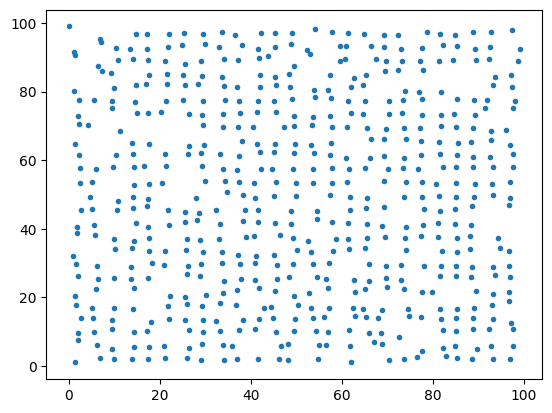

In [113]:
plt.scatter(cluster_means[:, 0], cluster_means[:, 1], marker=".")